# Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os


from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop


# Image Augmentation

In [81]:
def train_val_generators(TRAINING_DIR, TESTING_DIR):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest'
                                      )
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=15,
                                                       class_mode='categorical',
                                                       target_size=(150,150))
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                  batch_size=15,
                                                                 class_mode='categorical',
                                                                 target_size=(150, 150))
    
    return train_generator, validation_generator

In [82]:
TRAINING_DIR = "../ROBOTSDATASET/training/"
TESTING_DIR = "../ROBOTSDATASET/testing/"
train_generator, validation_generator = train_val_generators(TRAINING_DIR, TESTING_DIR)

Found 8013 images belonging to 19 classes.
Found 900 images belonging to 19 classes.


# Sequential Model

In [14]:
model_2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Rescaling(scale=1./255,  input_shape=(150, 150, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(19, activation='softmax')
])


# Print the model summary
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)      

In [15]:
# Set the training parameters
model_2.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
# Train the model
history_2 = model_2.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 17s 957ms/step - loss: 2.9736 - accuracy: 0.0844 - val_loss: 2.9569 - val_accuracy: 0.0667
Epoch 2/25
15/15 [==============================] - 17s 1s/step - loss: 2.9407 - accuracy: 0.0667 - val_loss: 2.9330 - val_accuracy: 0.0667
Epoch 3/25
15/15 [==============================] - 14s 905ms/step - loss: 2.9315 - accuracy: 0.0933 - val_loss: 2.9281 - val_accuracy: 0.0222
Epoch 4/25
15/15 [==============================] - 13s 890ms/step - loss: 2.9407 - accuracy: 0.0533 - val_loss: 2.9278 - val_accuracy: 0.0889
Epoch 5/25
15/15 [==============================] - 13s 868ms/step - loss: 2.9437 - accuracy: 0.0711 - val_loss: 2.9330 - val_accuracy: 0.1111
Epoch 6/25
15/15 [==============================] - 13s 830ms/step - loss: 2.9406 - accuracy: 0.0444 - val_loss: 2.9390 - val_accuracy: 0.0444
Epoch 7/25
15/15 [==============================] - 13s 827ms/step - loss: 2.9434 - accuracy: 0.0622 - val_loss: 2.9634 - val_accuracy: 0.0222
Ep

# Sequential 2 Without Rescaling

In [18]:
model_3 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(19, activation='softmax')
])


# Print the model summary
model_3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 17, 17, 128)     

In [19]:
# Set the training parameters
model_3.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [20]:
# Train the model
history_3 = model_3.fit(train_generator, epochs=25, steps_per_epoch=15, validation_data = validation_generator, validation_steps=3)

Epoch 1/25
15/15 [==============================] - 13s 777ms/step - loss: 3.1244 - accuracy: 0.0578 - val_loss: 2.9697 - val_accuracy: 0.0667
Epoch 2/25
15/15 [==============================] - 12s 819ms/step - loss: 2.9474 - accuracy: 0.0533 - val_loss: 2.9423 - val_accuracy: 0.1333
Epoch 3/25
15/15 [==============================] - 12s 816ms/step - loss: 2.9530 - accuracy: 0.0711 - val_loss: 2.9466 - val_accuracy: 0.0667
Epoch 4/25
15/15 [==============================] - 13s 881ms/step - loss: 2.9458 - accuracy: 0.0667 - val_loss: 2.9409 - val_accuracy: 0.0444
Epoch 5/25
15/15 [==============================] - 14s 932ms/step - loss: 2.9535 - accuracy: 0.0356 - val_loss: 2.9294 - val_accuracy: 0.1111
Epoch 6/25
15/15 [==============================] - 13s 889ms/step - loss: 2.9349 - accuracy: 0.0267 - val_loss: 2.8713 - val_accuracy: 0.0444
Epoch 7/25
15/15 [==============================] - 13s 829ms/step - loss: 2.9613 - accuracy: 0.1244 - val_loss: 2.8869 - val_accuracy: 0.1556

# InceptionV3

In [110]:
# Set the weights file you downloaded into a variable
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_inception = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None,
                                             )

pre = InceptionV3
# Load the pre-trained weights you downloaded.
pre_trained_model_inception.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_inception.layers:
    layer.trainable = False

In [111]:
pre_trained_model_inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_376 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                       

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_386 (Batch  (None, 16, 16, 96)  288         ['conv2d_386[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_387 (Batch  (None, 16, 16, 32)  96          ['conv2d_387[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_381 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_381[0][0]']
                                                                                                  
 activatio

 activation_398 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_398[0][0]']
                                                                                                  
 conv2d_396 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_399 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_398[0][0]']         
                                                                                                  
 batch_normalization_396 (Batch  (None, 16, 16, 48)  144         ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_399 (Batch  (None, 16, 16, 96)  288         ['conv2d_399[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_402[0][0]',         
                                                                  'activation_405[0][0]',         
                                                                  'max_pooling2d_18[0][0]']       
                                                                                                  
 conv2d_410 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_410 (Batch  (None, 7, 7, 128)   384         ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_410 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_410[0][0]']
          

                                                                                                  
 batch_normalization_420 (Batch  (None, 7, 7, 160)   480         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_420 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_420[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_420[0][0]']         
                                                                                                  
 batch_normalization_421 (Batch  (None, 7, 7, 160)   480         ['conv2d_421[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_431 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_430[0][0]']         
                                                                                                  
 batch_normalization_431 (Batch  (None, 7, 7, 160)   480         ['conv2d_431[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_431[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_43

                                                                                                  
 activation_441 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_441[0][0]']
                                                                                                  
 conv2d_437 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_442 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_441[0][0]']         
                                                                                                  
 batch_normalization_437 (Batch  (None, 7, 7, 192)   576         ['conv2d_437[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 conv2d_450 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_449[0][0]']         
                                                                                                  
 batch_normalization_446 (Batch  (None, 7, 7, 192)   576         ['conv2d_446[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_450 (Batch  (None, 7, 7, 192)   576         ['conv2d_450[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_446 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_446[0][0]']
                                                                                                  
 activatio

                                                                                                  
 activation_454 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_454[0][0]']
                                                                                                  
 activation_455 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_455[0][0]']
                                                                                                  
 activation_458 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_458[0][0]']
                                                                                                  
 activation_459 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_459[0][0]']
                                                                                                  
 batch_normalization_460 (Batch  (None, 3, 3, 192)   576         ['conv2d_460[0][0]']             
 Normaliza

                                                                                                  
 activation_468 (Activation)    (None, 3, 3, 384)    0           ['batch_normalization_468[0][0]']
                                                                                                  
 batch_normalization_469 (Batch  (None, 3, 3, 192)   576         ['conv2d_469[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_461 (Activation)    (None, 3, 3, 320)    0           ['batch_normalization_461[0][0]']
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_463[0][0]',         
                                                                  'activation_464[0][0]']         
          

In [112]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_inception.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [113]:
# Flatten the output layer to 1 dimension

x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dropout(0.2)(x) 
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (19, activation='softmax')(x)           

# Append the dense network to the base model
model_4 = Model(pre_trained_model_inception.input, x) 

model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_376 (Conv2D)            (None, 74, 74, 32)   864         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_376 (Batch  (None, 74, 74, 32)  96          ['conv2d_376[0][0]']             
 Normalization)                                                                                   
                                                                                            

 Normalization)                                                                                   
                                                                                                  
 batch_normalization_386 (Batch  (None, 16, 16, 96)  288         ['conv2d_386[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_387 (Batch  (None, 16, 16, 32)  96          ['conv2d_387[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_381 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_381[0][0]']
                                                                                                  
 activatio

 activation_398 (Activation)    (None, 16, 16, 64)   0           ['batch_normalization_398[0][0]']
                                                                                                  
 conv2d_396 (Conv2D)            (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_399 (Conv2D)            (None, 16, 16, 96)   55296       ['activation_398[0][0]']         
                                                                                                  
 batch_normalization_396 (Batch  (None, 16, 16, 48)  144         ['conv2d_396[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_399 (Batch  (None, 16, 16, 96)  288         ['conv2d_399[0][0]']             
 Normaliza

 mixed3 (Concatenate)           (None, 7, 7, 768)    0           ['activation_402[0][0]',         
                                                                  'activation_405[0][0]',         
                                                                  'max_pooling2d_18[0][0]']       
                                                                                                  
 conv2d_410 (Conv2D)            (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_410 (Batch  (None, 7, 7, 128)   384         ['conv2d_410[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_410 (Activation)    (None, 7, 7, 128)    0           ['batch_normalization_410[0][0]']
          

                                                                                                  
 batch_normalization_420 (Batch  (None, 7, 7, 160)   480         ['conv2d_420[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_420 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_420[0][0]']
                                                                                                  
 conv2d_421 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_420[0][0]']         
                                                                                                  
 batch_normalization_421 (Batch  (None, 7, 7, 160)   480         ['conv2d_421[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_431 (Conv2D)            (None, 7, 7, 160)    179200      ['activation_430[0][0]']         
                                                                                                  
 batch_normalization_431 (Batch  (None, 7, 7, 160)   480         ['conv2d_431[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_431 (Activation)    (None, 7, 7, 160)    0           ['batch_normalization_431[0][0]']
                                                                                                  
 conv2d_427 (Conv2D)            (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_43

                                                                                                  
 activation_441 (Activation)    (None, 7, 7, 192)    0           ['batch_normalization_441[0][0]']
                                                                                                  
 conv2d_437 (Conv2D)            (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_442 (Conv2D)            (None, 7, 7, 192)    258048      ['activation_441[0][0]']         
                                                                                                  
 batch_normalization_437 (Batch  (None, 7, 7, 192)   576         ['conv2d_437[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

In [114]:
model_4.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [115]:
# Train the model.
history_4 = model_4.fit(
            train_generator,
            steps_per_epoch=10,
            validation_data = validation_generator,
            epochs = 50,
            )

Epoch 1/50
10/10 [==============================] - 84s 7s/step - loss: 3.4423 - accuracy: 0.0533 - val_loss: 2.7055 - val_accuracy: 0.2178
Epoch 2/50
10/10 [==============================] - 37s 4s/step - loss: 2.9623 - accuracy: 0.1267 - val_loss: 2.3723 - val_accuracy: 0.3167
Epoch 3/50
10/10 [==============================] - 45s 5s/step - loss: 2.5345 - accuracy: 0.2000 - val_loss: 2.3504 - val_accuracy: 0.2944
Epoch 4/50
10/10 [==============================] - 33s 4s/step - loss: 2.4483 - accuracy: 0.2467 - val_loss: 2.1015 - val_accuracy: 0.3756
Epoch 5/50
10/10 [==============================] - 40s 4s/step - loss: 2.2232 - accuracy: 0.3200 - val_loss: 2.1662 - val_accuracy: 0.3233
Epoch 6/50
10/10 [==============================] - 39s 4s/step - loss: 2.4659 - accuracy: 0.2400 - val_loss: 1.7962 - val_accuracy: 0.4767
Epoch 7/50
10/10 [==============================] - 31s 3s/step - loss: 2.2348 - accuracy: 0.3067 - val_loss: 1.8756 - val_accuracy: 0.4144
Epoch 8/50
10/10 [==

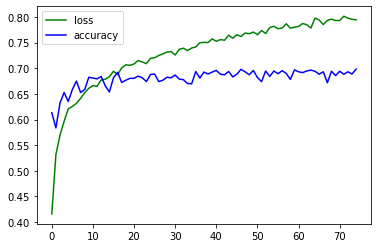

In [17]:
plt.plot(history_4.history['accuracy'], color='g')
plt.plot(history_4.history['val_accuracy'], color='b')
plt.legend(history_4.history)

In [303]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [307]:
# Set the weights file you downloaded into a variable
local_weights_file = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model_resnet = ResNet50(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model_resnet.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model_resnet.layers:
    layer.trainable = False

In [308]:
pre_trained_model_resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [309]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model_resnet.get_layer('conv4_block5_add')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 10, 10, 1024)


In [310]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense  (12, activation='sigmoid')(x)           

# Append the dense network to the base model
model_5 = Model(pre_trained_model_resnet.input, x) 

model_5.summary()

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 38, 38, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 38, 38, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 38, 38, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 38, 38, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 19, 19, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 19, 19, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 19, 19, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 19, 19, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

In [312]:
model_5.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

In [314]:
# Train the model.
history_5 = model_5.fit(
            train_generator,
            validation_data = validation_generator,
            epochs = 25,
            )

Epoch 1/25
128/128 [==============================] - 356s 3s/step - loss: 9.8425 - accuracy: 0.0787 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 2/25
128/128 [==============================] - 335s 3s/step - loss: 2.5760 - accuracy: 0.0855 - val_loss: 3.1765 - val_accuracy: 0.0832
Epoch 3/25
128/128 [==============================] - 356s 3s/step - loss: 2.5486 - accuracy: 0.0896 - val_loss: 2.4849 - val_accuracy: 0.0852
Epoch 4/25
128/128 [==============================] - 339s 3s/step - loss: 2.5491 - accuracy: 0.0844 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 5/25
128/128 [==============================] - 309s 2s/step - loss: 2.5258 - accuracy: 0.0797 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 6/25
128/128 [==============================] - 301s 2s/step - loss: 2.5293 - accuracy: 0.0730 - val_loss: 2.4849 - val_accuracy: 0.0832
Epoch 7/25
128/128 [==============================] - ETA: 0s - loss: 2.5050 - accuracy: 0.0776

KeyboardInterrupt: 

# Evaluating all model performance

In [317]:
h_1 = history_1.history['accuracy'][-1]
h_2  = history_2.history['accuracy'][-1]
h_3 = history_3.history['accuracy'][-1]
h_4 = history_4.history['accuracy'][-1]

In [318]:
df = pd.DataFrame({'Model':['MobileNetV2', 'Sequential_13', 'MobileNetV2', 'InceptionV3'], 'Accuracy':[h_1,  h_2, h_3,  h_4 ]})

In [319]:
df.head()

,Model,Accuracy
0,MobileNetV2,0.573333
1,Sequential_13,0.217778
2,MobileNetV2,0.535714
3,InceptionV3,0.880667


In [320]:
pd.DataFrame.to_csv(df, "Experimental_robots_dataset.csv")

In [18]:
model_4.save('models/experimental/model_4_robots_balanced_20')

INFO:tensorflow:Assets written to: models/experimental/model_4_robots_balanced_20\assets


# Testing Prediction

In [79]:
train_generator.class_indices

{'abyssinian': 0,
 'bengal': 1,
 'birman': 2,
 'bombay': 3,
 'british_shorthair': 4,
 'calico': 5,
 'dilute_calico': 6,
 'domestic_long_hair': 7,
 'egyptian_mau': 8,
 'himalayan': 9,
 'maine_coon': 10,
 'persian': 11,
 'ragdoll': 12,
 'russian_blue': 13,
 'scottish_fold': 14,
 'siamese': 15,
 'sphynx': 16,
 'turkish_angora': 17,
 'tuxedo': 18}

In [80]:
list_of_class = [key for  key,value in train_generator.class_indices.items()]
list_of_class

['abyssinian',
 'bengal',
 'birman',
 'bombay',
 'british_shorthair',
 'calico',
 'dilute_calico',
 'domestic_long_hair',
 'egyptian_mau',
 'himalayan',
 'maine_coon',
 'persian',
 'ragdoll',
 'russian_blue',
 'scottish_fold',
 'siamese',
 'sphynx',
 'turkish_angora',
 'tuxedo']

In [5]:
# Load in the SavedModel format
saved_model = tf.keras.models.load_model('model_4_robots_balanced_20')

Predicted:  dilute_calico
Real:  dilute_calico


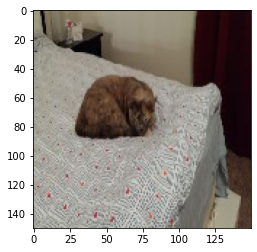

In [78]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import random
import os

class_name = "dilute_calico"
random_image = random.sample(os.listdir(f'../ROBOTSDATASET/testing/{class_name}/'), 1)
img_path = f"../ROBOTSDATASET/testing/{class_name}/" + random_image[0]
img = image.load_img(img_path, target_size=(150, 150))
x = image.img_to_array(img)
x = x/255.
x = np.expand_dims(x, axis=0)
print("Predicted: " , list_of_class[np.argmax(saved_model.predict(x))])
print("Real: ", class_name)
plt.imshow(img)



# Saving the model and convert into TFLite

In [19]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [20]:
export_dir = 'model_2'
tf.saved_model.save(model_4, export_dir)

INFO:tensorflow:Assets written to: model_2\assets


In [21]:

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [22]:
tflite_model_file = pathlib.Path('model_2.tflite')
tflite_model_file.write_bytes(tflite_model)

47777616

In [23]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()



In [24]:
import os

with open('labels.txt', 'w') as f:
    for label in os.listdir('../ROBOTSDATASET/training/'):
        f.writelines(f'{label}\n')